This notebook is an exploration of the Pliable Lasso. The paper which introduces the Pliable Lasso is linked below. Also linked below is a reposity of a python implimentation. 

https://github.com/arose13/PliableLasso

https://arxiv.org/abs/1712.00484


I present the following situation to test how various models perform. x1,x2(0) show strong positive corelation with target y, x1,x2(1) show strong negitive corelation with target y. 

In [141]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import *
from sklearn.ensemble import *

In [142]:
from sklearn.neural_network import *

In [143]:
import plasso as pl

Make some data. The pliable lasso is useful when one of your variables is a discrete binary variable, for instance if you are encoding if a light switch is on or off. In the below case y will encode x2 = 1 and y_2 represents x2 = 0 

In [144]:
b = 0
b_two = 2
m = 2
m_two = -2

In [145]:
x = np.random.random(size=100)

In [146]:
y = x*m + b
y_2 = x*m_two + b_two

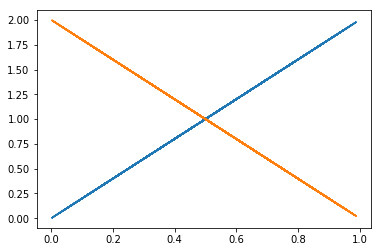

In [147]:
plt.plot(x,y)
plt.plot(x,y_2)

Above we created two distinct data sets, however we are treating data as one complete set. so we need to combine data.

In [148]:
x = x.reshape(100,1)

In [149]:
ones = np.ones((100,1),dtype='int8')
zeros = np.zeros((100,1), dtype='int8')
x_1 = np.hstack(((x,ones)))
x_2 = np.hstack((x,zeros))
x = np.concatenate((x_1,x_2))

In [150]:
y = np.concatenate((y,y_2))

In [151]:
y.shape

(200,)

In [152]:
x[:,:1].shape

(200, 1)

So what does this data look like?

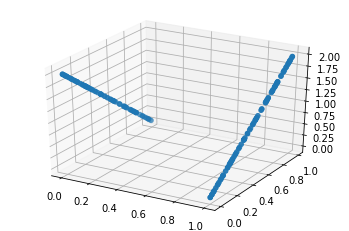

In [153]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,1:2],x[:,:1],y)
plt.show()

In [ ]:
x[:,:]

In [155]:
cont_max = x[:,:1].max()
cont_min = x[:,:1].min()

In [184]:
def plot_regression(model,cont_min,cont_max):
    plane_x = np.linspace(0,1)
    plane_z = np.linspace(cont_min,cont_max)
    y_list = []
    y_point_one_list = []
    y_point_zero_list = []
    for idx in range(50):
        point = np.array([plane_z[idx],plane_x[idx]])
        point = point.reshape(1,-1)
        y_point = model.predict(point)
        y_list.append(y_point)
    for idx_2 in range(50):
        point_zero = np.array([plane_z[idx_2],0])
        point_one = np.array([plane_z[idx_2],1])
        y_point_zero = model.predict(point_zero.reshape(1,-1))
        y_point_one = model.predict(point_one.reshape(1,-1))
        y_point_one_list.append(y_point_one)
        y_point_zero_list.append(y_point_zero)
    
    
    y_list = np.array(y_list)
    plt.plot(plane_z, y_point_one_list, color='red', label='Model Predictions')
    plt.scatter(x[0:100,:1],y[:100], color='blue', marker='x', alpha=.5, label='Ground Truth')
    plt.legend()
    plt.title("Predicting x2 == 1")
    plt.show()
    
    plt.plot(plane_z, y_point_zero_list, color='red', label='Model Predictions')
    plt.scatter(x[100:200,:1],y[100:200], color='blue', marker='x', alpha=.5, label='Ground Truth')
    plt.legend()
    plt.title("Predicting x2 == 0")
    plt.show()


 Can we fit a regression to this data? 

In [180]:
lin_mod = LinearRegression()
lin_mod.fit(x,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

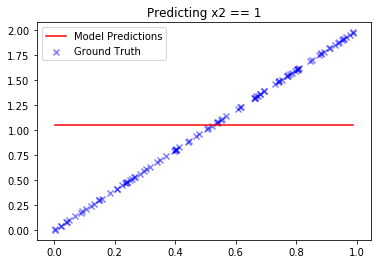

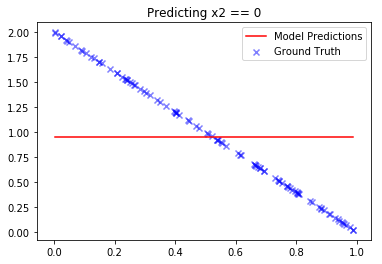

In [185]:
plot_regression(lin_mod,cont_min,cont_max)

In [159]:
forest_mod = RandomForestRegressor(n_estimators=100)
forest_mod.fit(x,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

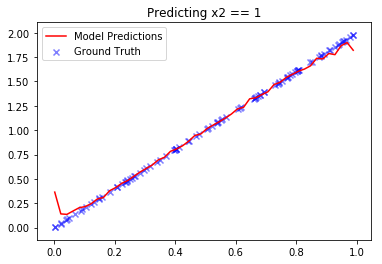

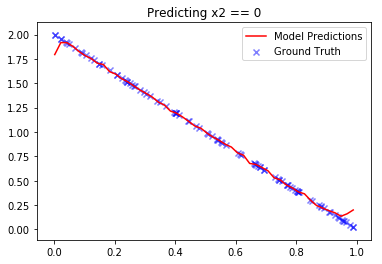

In [186]:
plot_regression(forest_mod,cont_min,cont_max)

In [161]:
gb_mod = GradientBoostingRegressor()
gb_mod.fit(x,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

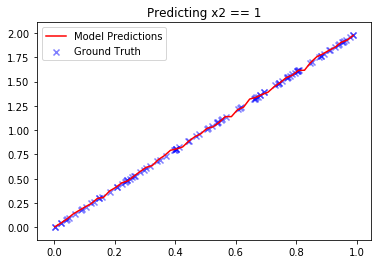

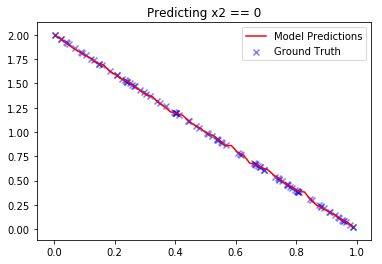

In [187]:
plot_regression(gb_mod,cont_min,cont_max)

In [163]:
nn_mod = MLPRegressor()
nn_mod.fit(x,y)

C:\Users\Kris\Anaconda3\envs\plasso\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

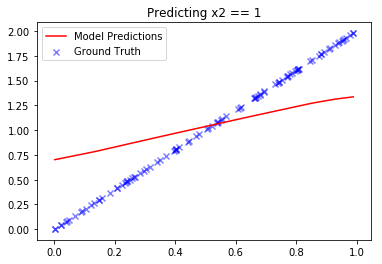

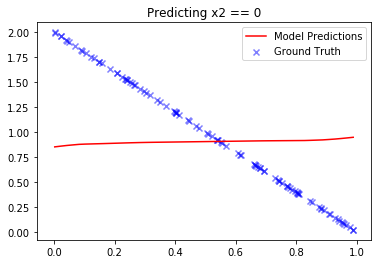

In [188]:
plot_regression(nn_mod,cont_min,cont_max)

Now lets try to model the data using the Pliable Lasso. First we need to create a z matrix which is x2, our discrete binary variable (1 or 0) 

In [165]:
z = x[:,1].reshape(-1, 1)
z.shape

(200, 1)

In [207]:
x_mod = x[:,0].reshape(-1, 1)

In [208]:
x_mod.shape

(200, 1)

In [209]:
y.shape

(200,)

In [198]:
plmodel = pl.PliableLasso()
plmodel.fit(x_mod, z, y)

PliableLasso(alpha=0.5, backend='cpu', cv=3, enable_caching=True, eps=0.01,
             max_interaction_terms=500, max_iter=100,
             metric=<function mean_squared_error at 0x0000025447D45488>,
             min_lam=0.004988653345335266, n_lam=50, normalize=True,
             verbose=False)

Above I created new test data to create y_hat. For the Pliable Lasso model I reused the train data to create y_hat. While inappropriate in a production type setting, for this exploration like notebook it is a sufficient technique. 

In [200]:
y_hat = plmodel.predict(x_mod, z)

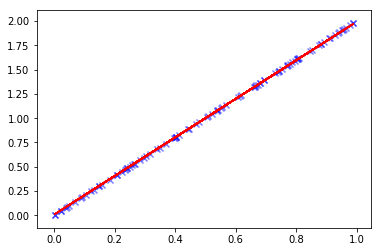

In [201]:
plt.plot(x_mod[:100], y_hat[:100], color='red', label='Pliable Lasso Predictions')
plt.scatter(x_mod[:100], y[:100], color='blue', marker='x', alpha=.5, label='Ground Truth')
plt.legend()
plt.title("Predicting x2 == 1")
plt.show()

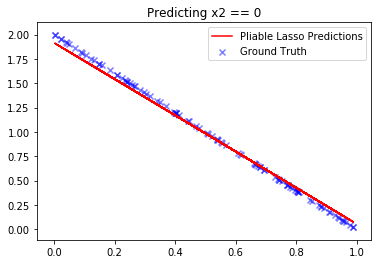

In [206]:
plt.plot(x_mod[100:200], y_hat[100:200],color='red', label='Pliable Lasso Predictions')
plt.scatter(x_mod[100:200], y[100:200], color='blue', marker='x', alpha=.5, label='Ground Truth')
plt.legend()
plt.title("Predicting x2 == 0")
plt.show()